## HW 7 problem 1 MPO

###  Part (a) for Ising transverse field
**note that first use Python2 then switch to Julia**
+ $H = \sum_{i=1}^{N-1} S_i^z S_{i+1}^z +h\sum_{i=1}^N S_i^x$

In [6]:
import numpy as np
import sympy as sp
import scipy as scp

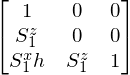

In [29]:
# x,h,z = sy.symbols("x,h,z")
sp.init_printing()
def A(i):
    x,h,z = sp.symbols("S^x_{},h,S^z_{}".format(i,i))
    return sp.Matrix([[1,0,0],[z,0,0],[h*x,z,1]])
A(1)

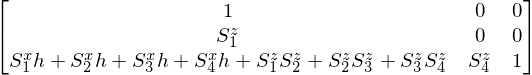

In [30]:
A(1)*A(2)*A(3)*A(4)

In [31]:
(sp.Matrix([[0,0,1]])*A(1)*A(2)*A(3)*A(4)*sp.Matrix([1,0,0]))[0]

## Part (b)

### Writing Heisenberg chain MPO and find GS energy

**Switch to Julia**

In [118]:
# %%script julia
sz = Float64[0.5 0; 
	     0 -0.5]
sp = Float64[0 1; 
	     0 0]
sm = sp'
sx = .5 *(sm + sp)

sz = sparse(sz)
sp = sparse(sp)
sm = sparse(sm)
one = speye(2)

Hn = cell(20)
# Htwon = cell(20)

function getHkronsparse(n, jxy, jz, h)
    H_tilde = jxy * 0.5 * (kron(sp,sm) + kron(sm,sp)) + jz * kron(sz,sz) + h * kron(one, sx)
    Hn[2] = H_tilde + h * kron(sx, one)
    for k=3:n
# 	Htwon[k] = kron(one,Htwon[k-1])
        Hn[k] = kron(Hn[k-1],one) + kron(speye(2^(k-2)), H_tilde)
    end
    Hn
end

### I want to test the function with the one I had from previous homewok
function getHkronsparse_edge_B(n, B)
    Hn[2] = 0.5 * (kron(sp,sm) + kron(sm,sp)) + kron(sz,sz) + B * kron(one, sz)
    Htwon = 0.5 * (kron(sp,sm) + kron(sm,sp)) + kron(sz,sz)
    for k=3:n

        Htwon = kron(Htwon, one)
        Hn[k] = kron(one, Hn[k-1]) + Htwon
    end
    Hn
end

H = getHkronsparse(8, 1, 1, 0)[n]
Htest = getHkronsparse_edge_B(8, 0)[n]
@show Htest ==H

# transverse Ising model
n, jxy, jz, h = 8, 0, 1, 1

H = getHkronsparse(n, jxy, jz, h)[n]
ev = eigs(H, nev=1, which=:SR)
GS = ev[2][:,1];
E_lanczos = ev[1]

# @show full(getHkronsparse(n, jxy, jz, h)[2])

Htest == H = true


1-element Array{Float64,1}:
 -4.22129

In [119]:
zero = zeros(2,2)
M =[one zero zero;
    sz zero zero;
    sx sz one]
# @show M
MPO = reshape(M,2,3,2,3)
v1 = [0, 0, 1]
v2 = [1, 0, 0]
using TensorOperations
@tensor begin
    H_MPO[s1,s2,s1p, s2p] := v1[i]*MPO[s1,i,s1p,j]*MPO[s2,j,s2p,k]*v2[k]
end
#  test that the implimentation for MPO is correct 
H_two_site = reshape(H_MPO,4,4)
@show H_two_site ==full(getHkronsparse(n, jxy, jz, h)[2])


H_two_site == full((getHkronsparse(n,jxy,jz,h))[2]) = true


true

### Now let us try it for 8 sites

In [120]:
d=2
D=3 # size of MPO matrix
MPO = reshape(M, d, D, d, D)

@tensor begin
    temp1[s1, s1p, j]  := v1[i] * MPO[s1,i,s1p,j]
end
for i=1:n-1
    @tensor begin
    temp2[s1, s2, s1p, s2p, j] := temp1[s1, s1p, i] * MPO[s2,i,s2p,j]
    end
    temp1 = reshape(temp2, d^(i+1), d^(i+1), D)
end

@tensor begin
    H_MPO[s1, s1p] := temp1[s1, s1p, k] * v2[k]
end
# @show size(H_MPO)
H8 = reshape(H_MPO, d^n, d^n)

# this is to check that I got the Hamiltonian out of MPO correctly 
@show H8==H
@show Expectation_Energy = GS' * H8 *GS 
println("\n")
@show Expectation_Energy - E_lanczos ;



H8 == H = true
Expectation_Energy = GS' * H8 * GS = [-4.221285373302035]


Expectation_Energy - E_lanczos = [1.7763568394002505e-15]


### Part (c) convert the ground state to MPS form

szie(A[1]) =(1, 2, 2)
szie(A[2]) =(2, 2, 4)
szie(A[3]) =(4, 2, 8)
szie(A[4]) =(8, 2, 16)
szie(A[5]) =(16, 2, 8)
szie(A[6]) =(8, 2, 4)
szie(A[7]) =(4, 2, 2)
szie(A[8]) =(2, 2, 1)


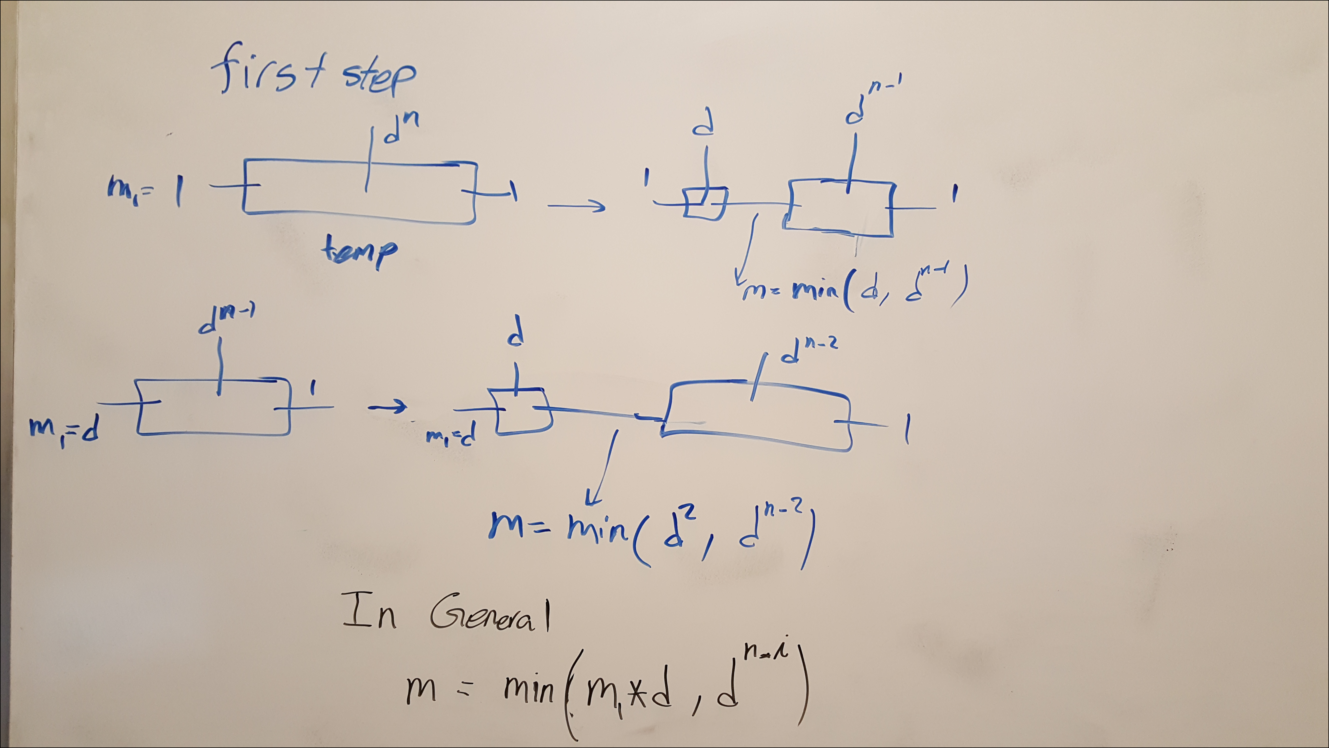

In [121]:
using TestImages, Images
A = []
temp = reshape(copy(GS), 1, d^n,1)
for i=1:n
    m1 = size(temp,1)
    Q, R = qr(reshape(temp, m1 * d, d^(n-i)))
    m = min(d * m1, d^(n-i))
    push!(A, reshape(Q,m1, d, m))
    println("szie(A[$i]) =($m1, $d, $m)")
    temp = reshape(R, m, d^(n-i), 1)
end
load("MPS_from_GS.jpg")

In [122]:
function normsq3(A)
    n = size(A,1)
    C = A[1]
    A2 = zeros(A[1])
    A1 = zeros(A[1])
    for x=1:n-1
        A2 = A[x+1]
#         @show A2
        A1 = A[x]
#         @show A1
        @tensor begin
            C[i,j,k] := A1[ip,jp,i] * C[ip,jp,kp] * A2[kp,j,k]
        end
    end
#     An = A
    @tensor begin
        answer = scalar(C[i,j,k] * A2[i,j,k])
        end
    answer
end
@time normsq3(A)

  0.031337 seconds (15.06 k allocations: 600.480 KB)


0.9999999999999999

### find the expectation value using MPO and MPS
**( look at the picture below to how it works)**

size(X) = (2,1,2,3)
size(X) = (4,2,2,3)
size(X) = (8,4,2,3)
size(X) = (16,8,2,3)
size(X) = (8,16,2,3)
size(X) = (4,8,2,3)
size(X) = (2,4,2,3)
abs((E_MPO - E_lanczos)[1]) < 1.0e-14 = true
GS Energy difference between Lanczos and MPO = 6.217248937900877e-15
GS Energy difference between Lanczos and MPO = 6.217249e-15

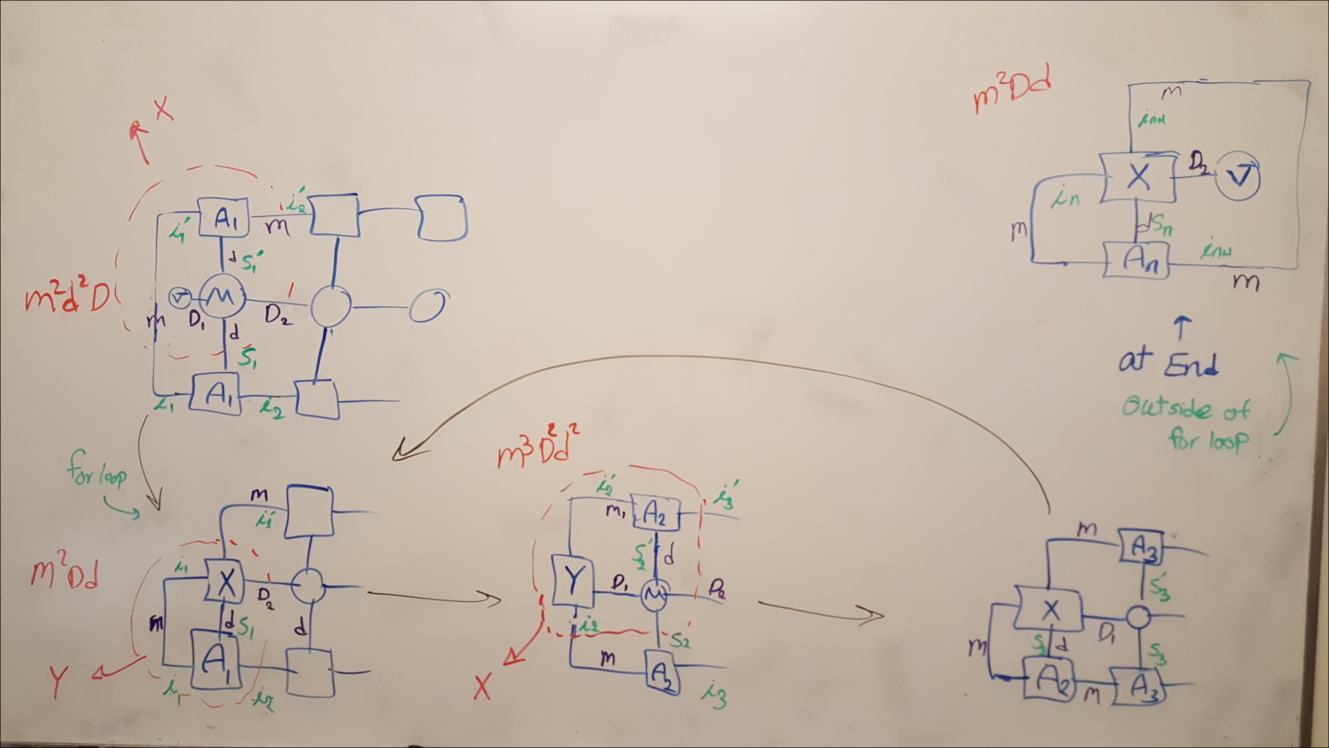

In [157]:
A1 = A[1]
@tensor begin
    #index are clockwise starting from top except A_i which are from left to right
    X[i2p,i1p,s1,D2] := v1[D1] * MPO[s1p,D1,s1,D2] * A1[i1p,s1p,i2p] 
end
for i=1:n-1
    Ai = A[i]
    Ai1 = A[i+1]
    @show size(X)
    @tensor begin
        Y[i2,D2,i2p] := X[i2p,i1,s1,D2] * Ai[i1,s1,i2]
        X[i3p,i2,s2,D2] := Y[i2,D1,i2p] * MPO[s2p,D1,s2,D2] * Ai1[i2p,s2p,i3p]
    end
end
An = A[n]
@tensor begin
    E_MPO = scalar(X[i_n1,i_n,sn,D2] * An[i_n,sn,i_n1] * v2[D2])
end

@show abs((E_MPO - E_lanczos)[1]) < 1e-14
diff = abs(E_MPO - E_lanczos)[1]
println( "GS Energy difference between Lanczos and MPO = $diff" )
@printf "GS Energy difference between Lanczos and MPO = %e" diff
load("MPO-contracting.jpg")